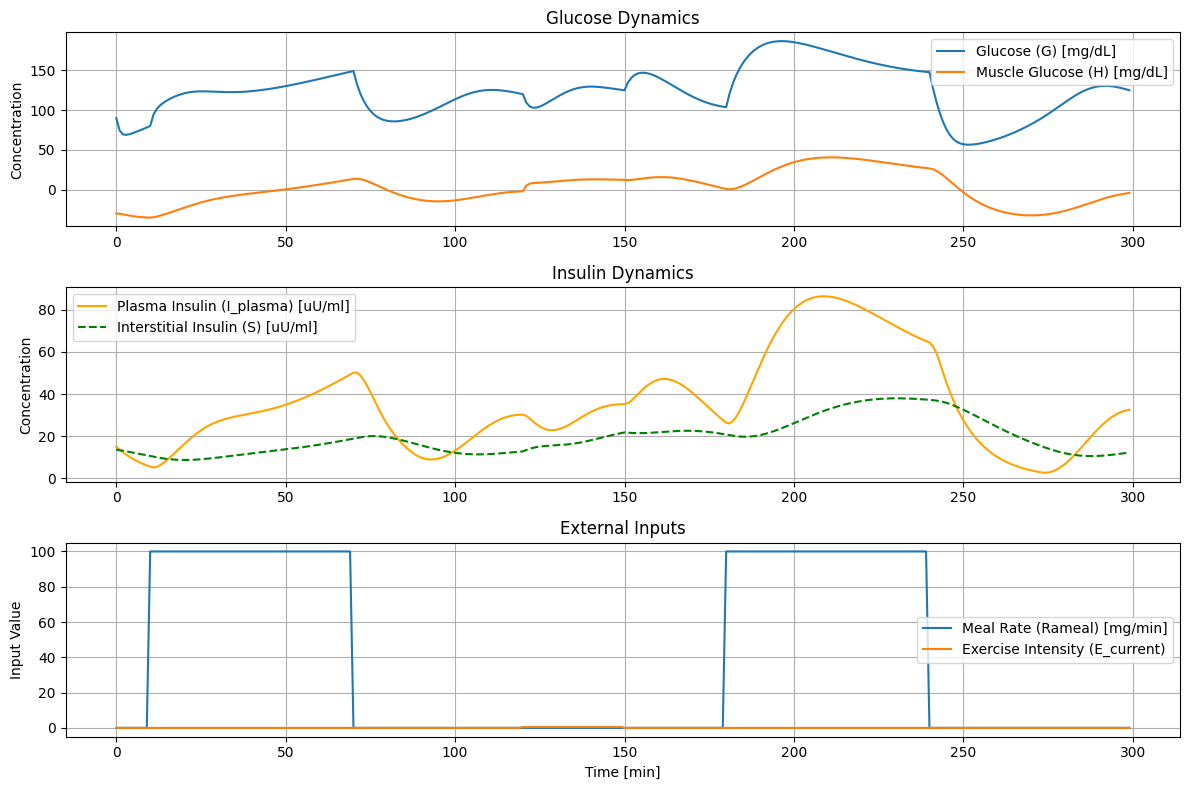

In [ ]:
from model import GlucoseDynamicsSimulator
from scipy.integrate import odeint
import numpy as np

def get_inputs_for_t( t):
    Rameal_current = 0.0
    E_current = 0.0

    meal_event_occurred = False
    exercise_event_occurred = False

    # Meal event: 6000 mg glucose over 60 minutes, starting at t=10 and t=180
    if 10 <= t < 70: # Meal 1 starts at 10 min, lasts 60 min
        Rameal_current = 6000 / 60 # mg/min
        if t == 10: 
            meal_event_occurred = True
    elif 180 <= t < 240:
        Rameal_current = 6000 / 60 # mg/min
        if t == 180: 
            meal_event_occurred = True

    # Exercise event: E=0.5 for 30 minutes, starting at t=120
    if 120 <= t < 150: # Exercise starts at 120 min, lasts 30 min
        E_current = 0.5
        if t == 120:
            exercise_event_occurred = True

    return (Rameal_current, E_current, meal_event_occurred, exercise_event_occurred)

sim = GlucoseDynamicsSimulator()
y0 = sim.initial_conditions()
t_span = np.arange(0, 300, 1) # Simulate for 300 minutes, 1-minute steps

def odes_for_solver(y, t, sim_instance):
    """
    Wrapper for sim.odes to be used with odeint.
    It takes the current time 't' and generates inputs dynamically.
    """
    inputs = get_inputs_for_t(t)
    return sim_instance.odes(y, inputs)

solution = odeint(odes_for_solver, y0, t_span, args=(sim,))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t_span, solution[:, 0], label='Glucose (G) [mg/dL]')
plt.plot(t_span, solution[:, 1], label='Muscle Glucose (H) [mg/dL]')
plt.ylabel('Concentration')
plt.title('Glucose Dynamics')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_span, solution[:, 7], label='Plasma Insulin (I_plasma) [uU/ml]', color='orange') # I_plasma is the last state variable
plt.plot(t_span, solution[:, 2], label='Interstitial Insulin (S) [uU/ml]', color='green', linestyle='--')
plt.ylabel('Concentration')
plt.title('Insulin Dynamics')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
rameal_over_time = [get_inputs_for_t(t)[0] for t in t_span]
e_current_over_time = [get_inputs_for_t(t)[1] for t in t_span]
plt.plot(t_span, rameal_over_time, label='Meal Rate (Rameal) [mg/min]')
plt.plot(t_span, e_current_over_time, label='Exercise Intensity (E_current)')
plt.ylabel('Input Value')
plt.xlabel('Time [min]')
plt.title('External Inputs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
from glucose_env import CustomGlucoseDynamicsEnv

env = CustomGlucoseDynamicsEnv()

obs, info = env.reset()
print("Initial observation:", obs)

done = False
truncated = False

step_count = 0

while not done and not truncated and step_count < 288:
    action = {
        "meal_category": np.random.choice(4),
        "exercise_mode": np.random.choice(2),
        "exercise_intensity": np.random.choice(4),
        "exercise_duration": np.random.choice(13)
    }
    obs, reward, done, truncated, info = env.step(action)
    print(
        f"Step {step_count} | "
        f"reward: {reward:.2f} | glucose: {obs[0]:.2f} | "
        f"action: meal_cat={action['meal_category']}, "
        f"ex_mode={action['exercise_mode']}, "
        f"ex_intensity={action['exercise_intensity']}, "
        f"ex_duration={action['exercise_duration']}"
    )
    step_count += 1


Initial observation: [  96.03923     96.03923      5.6033583 1440.           0.
    0.           0.        1440.           0.           0.       ]
Step 0 | reward: 79.00 | glucose: 138.86 | action: meal_cat=1, ex_mode=1, ex_intensity=1, ex_duration=2
Step 1 | reward: -21.00 | glucose: 141.90 | action: meal_cat=2, ex_mode=1, ex_intensity=2, ex_duration=12
Step 2 | reward: -14.19 | glucose: 113.06 | action: meal_cat=0, ex_mode=0, ex_intensity=3, ex_duration=3
Step 3 | reward: 80.00 | glucose: 123.61 | action: meal_cat=0, ex_mode=1, ex_intensity=2, ex_duration=8
Step 4 | reward: 79.00 | glucose: 103.52 | action: meal_cat=3, ex_mode=1, ex_intensity=3, ex_duration=7
Step 5 | reward: 80.00 | glucose: 118.38 | action: meal_cat=3, ex_mode=0, ex_intensity=3, ex_duration=2
Step 6 | reward: 80.00 | glucose: 115.38 | action: meal_cat=3, ex_mode=0, ex_intensity=0, ex_duration=11
Step 7 | reward: 80.00 | glucose: 114.68 | action: meal_cat=2, ex_mode=0, ex_intensity=2, ex_duration=5
Step 8 | reward: 